In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FOLDERNAME = '/CSRNet'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME


/content/drive/My Drive/CSRNet


In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
from torchvision import datasets, transforms
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
#from image import *
from model import CSRNet
import torch
from scipy import spatial
%matplotlib inline

In [ ]:


def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    m,n = pts.shape
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [ ]:
path = glob.glob('/content/drive/MyDrive/CSRNet/crowd_data/*.jpg')
path

['/content/drive/MyDrive/CSRNet/crowd_data/IMG_1.jpg',
 '/content/drive/MyDrive/CSRNet/crowd_data/IMG_10.jpg',
 '/content/drive/MyDrive/CSRNet/crowd_data/IMG_100.jpg']

In [ ]:
for img_path in path:
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    k = gaussian_filter_density(k)

    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

(704, 1024)
generate density...
done.
(768, 1024)
generate density...
done.
(409, 902)
generate density...
done.


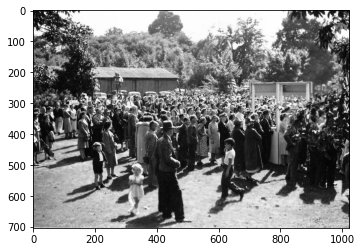

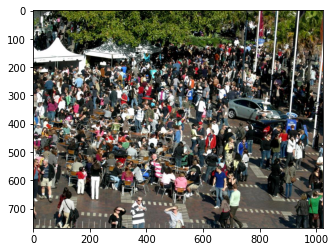

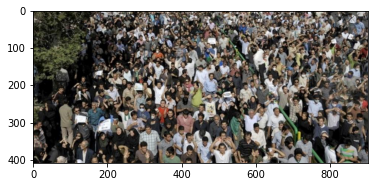

In [ ]:
#now see a sample from ShanghaiA

for i in range(len(path)):
  plt.imshow(Image.open(path[i]))
  plt.show()

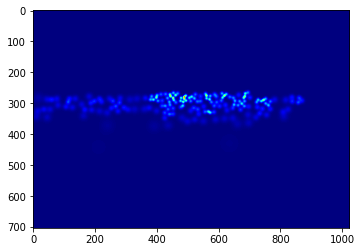

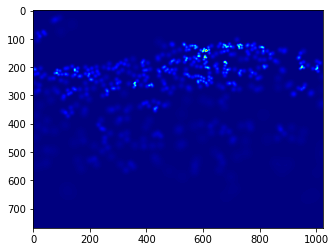

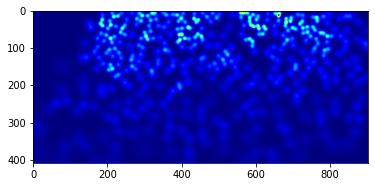

In [ ]:
count = []
for i in range(len(path)):
  gt_file = h5py.File(path[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
  groundtruth = np.asarray(gt_file['density'])
  count.append(round(np.sum(groundtruth)))
  plt.imshow(groundtruth,cmap=CM.jet)
  plt.show()

In [ ]:
count

[172, 497, 382]

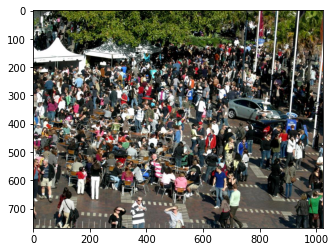

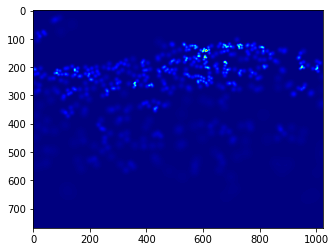

count of person in count   497


In [ ]:
plt.imshow(Image.open(path[1]))
plt.show()

gt_file = h5py.File(path[1].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
plt.show()
print("count of person in count  ",round(np.sum(groundtruth)))
